#Traffic Simulation - Hard Mode
The goal of this simulation is to model the traffic patterns that develop on a busy section of road in order to select an appropriate speed limit. The traffic model is based on emergent behavior with 30 individual Car objects per kilometer, each tracking its own speed and location as well as the location of the car in front (to avoid collisions). The road is a loop 7km long, with each kilometer having a slowing factor from 1.0 to 2.0 defined, which will affect the traffic patterns.

##Assumptions
* Drivers want to go up to 120 km/hr.
* The average car is 5 meters long.
* Drivers want at least a number of meters equal to their speed in meters/second between them and the next car.
* Drivers will accelerate 2 m/s up to their desired speed as long as they have room to do so.
* If another car is too close, drivers will match that car's speed until they have room again.
* If a driver would hit another car by continuing, they stop.
* Drivers will randomly (10% chance each second) slow by 2 m/s.
* This section of road is one lane going one way.

###Additional Assumptions and Implementation Details
* All units within the program and its output are in meters, seconds, or meters per second. Multiplying meters per second by 3.6 yields kilometers per hour.
* Velocities and positions are calculated discretely for each car at 1s intervals.
* Drivers can instantly brake if in danger of "leapfrogging" the leading car.
* The likelihood of random slowing is doubled for a driver in any step where they have already been forced to brake.
_This was not specified in the original assumption, but appears to yield more traffic waves at the specified settings, and meshes with real-world driver behavior, so was implemented in the simulations shown below. Without this effect, mean speeds tended to be within a standard deviation of the desired speed._

##Simulation setup
In order to get the simulation started, we first have to import the Car, Road, and Simulation modules, as well as numpy (for numerical arrays and math), pyplot for visualizing results, and the statistics module for some basic statistical functions. The matplotlib graphics are also set here to appear inline in this document.

In [1]:
from car import Car
from road import Road
from simulation import Simulation
import numpy as np
#from unittest import mock
import matplotlib.pyplot as plt
#from statistics import mean, stdev as mean, stdev
import statistics as st
%matplotlib inline

Next, several functions are declared in order to make the list of evenly-spaced car objects, run and plot a single simulation, and run a trial with a number of simulations, providing data to analyze. Note that the lower-level behaviors are defined in car.py, road.py, and simulation.py. Test suites for these modules are also provided, but not shown in this notebook.

In [2]:

def make_cars(num=10, slowing_chance=0.1, desired_speed=33.333, length=1000, hard_road=False):
    """
    Return a list of Car objects of length num, each defined with
    a probability of slowing (0-1) at each turn, a desired speed
    in m/s, and the length of the (looping) Road they travel on.
    Note that Cars default to an initial speed of 15 m/s.
    Cars are evenly spaced across the length.
    """
    road = Road(length=length, hard_road=hard_road)
    start_positions = list(np.linspace(length,0,num+1))[1:]
    cars = []
    for i in start_positions:
        car = Car(road, position=i, slowing_chance=slowing_chance, desired_speed=desired_speed) # reverse order required here...
        cars.append(car)
    return cars

In [3]:
def run_sim(cars, discard_steps=60, run_steps=300):
    """
    Runs a Simulation with the provided list of cars,
    discarding the results of the specified number of initial
    steps, then running an additional number of run steps
    specified. At completeion, a 4-tuple is returned containing
    the list of positions at each step for each car, the list of
    speeds at each step for each car, the mean speed, and the
    standard deviation of the speeds.
    """
    sim = Simulation(cars=cars, steps=discard_steps)
    sim.start()
    sim.run()

    sim = Simulation(cars=cars, steps=run_steps)

    sim.start()
    positions, speeds = sim.run()
    return positions, speeds, speeds[:, 0].mean(), speeds[:, 0].std()

In [4]:
def plot_sim(title, cars, positions, speeds):
    """
    Makes a 5-color scatter plot of the positions of cars (y-axis)
    versus time step (x-axis). Requires a title for the plot, a list
    of cars, a list of positions and a list of speeds for each time
    step for each car. In addition to the plot, it returns the mean
    speed across all cars/steps as well as the standard deviation.
    """
    plt.xlabel("Time (s)")
    plt.ylabel("Position (m)")
    plt.title(title)
    for i in range(0, len(cars), 5):
        plt.scatter(range(len(positions)), positions[:,i], marker='_')
        plt.scatter(range(len(positions)), positions[:,i+1], c='r', marker='_')
        plt.scatter(range(len(positions)), positions[:,i+2], c='g', marker='_')
        plt.scatter(range(len(positions)), positions[:,i+3], c='y', marker='_')
        plt.scatter(range(len(positions)), positions[:,i+4], c='m', marker='_')
        plt.subplots_adjust(left=2, right=4)
    avg = speeds[:, 0].mean()
    stdev = speeds[:, 0].std()
    print('mean: {} std: {}'.format(avg, stdev))
    return avg, stdev

In [5]:
def run_trial(num_trials=100, discard_steps=60, run_steps=60, num_cars=30,
              slowing_chance=0.1, desired_speed=33.333, length=1000, hard_road=False):
    """
    Sets up the entire simulation and runs for the number of trials
    specified. Each step has the simulation and Car parameters passed in,
    including the number of initial steps to discard, and the number of
    subsequent steps to capture, as well as the number of cars, the
    probability of random slowing for each car, the optimal/max speed
    for the cars, and the length of the road.
    Upon completion, a single plot (the last simulation run) is shown,
    and a list of 4-tuples from each run_sim() run is returned.
    """
    data = []
    cars = []
    positions = []
    speeds = []
    for i in range(num_trials):
        cars = make_cars(num=num_cars, length=length, slowing_chance=slowing_chance,
                         desired_speed=desired_speed, hard_road=hard_road)
        (positions, speeds, avg, stdev) = run_sim(cars=cars, discard_steps=discard_steps, run_steps=run_steps)
        data.append((positions, speeds, avg, stdev))
    
    plot_sim('{} cars, {}% slowing chance, {} m/s desired speed'.format(
            num_cars, slowing_chance*100, desired_speed),
            cars, positions, speeds
            )
    return data

##Initial simulation run
We first run a short trial to verify that everything is functioning as expected, and get a sense of the time required to run a simulation.

mean: 19.273147540983608 std: 10.8160515671303


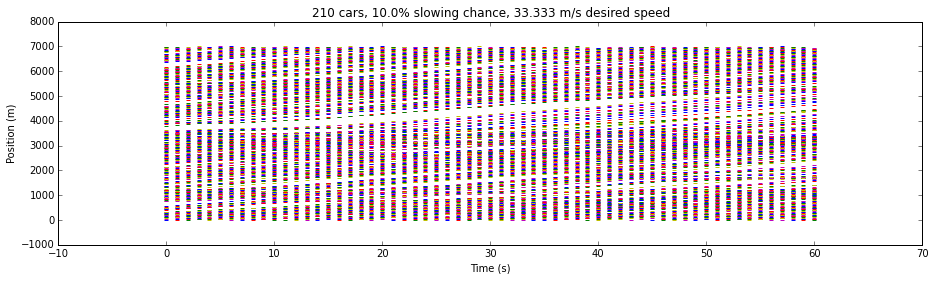

In [6]:
data = run_trial(num_trials=2, discard_steps=30, run_steps=60, num_cars=210,
              slowing_chance=0.1, desired_speed=33.333, length=7000, hard_road=True)

###Observations
The above plot shows a series of vertical groupings of car positions (y-axis) from time 0 to 60 (x-axis), with adjacent cars in different colors. Any single car can be followed through the time steps as it travels up the y-axis for each step in time. The faster the car is travelling, the farther up the axis it travels, and thus the higher the perceived slope. As cars are slowed down by the traffic jam, the slope becomes more horizontal. At first glance, this appears to be realistic behavior.
In the plot above, we can see evidence of non-deterministic behavior with "waves" of closely-packed and wide-apart cars. Note that the mean speed of 22.5 m/s is signicantly lower than the target speed for each car (33.333 m/s), indicating that traffic is impeding their progress overall. The somewhat high standard deviation is likely a result of the appearance and disappearance of the traffic "compressions" over the 60 seconds of the run.

A snapshot of the data object returned from the simulation trials is below. It is a list of 4-tuples, one for each trial. Each 4-tuple contains numpy arrays of positions and speeds of each step for each car within the simulation, then the mean and standard deviation of the speeds. The means and standard deviations are pulled out into two new lists with the list comprehension below.

In [7]:
data

[(array([[  669.66566667,   637.99933333,   608.666     , ...,
            766.66666667,   739.33333333,   712.666     ],
         [  698.66566667,   664.99933333,   629.666     , ...,
            787.66666667,   760.33333333,   733.666     ],
         [  729.66566667,   693.99933333,   648.666     , ...,
            810.66666667,   779.33333333,   756.666     ],
         ..., 
         [ 1993.33166667,  1962.66533333,  1915.999     , ...,
           2094.66666667,  2069.33333333,  2048.666     ],
         [ 2021.33166667,  1988.66533333,  1933.999     , ...,
           2112.66666667,  2087.33333333,  2064.666     ],
         [ 2051.33166667,  2016.66533333,  1953.999     , ...,
           2132.66666667,  2107.33333333,  2082.666     ]]),
  array([[ 27.,  25.,  23., ...,  19.,  29.,  29.],
         [ 29.,  27.,  21., ...,  21.,  21.,  21.],
         [ 31.,  29.,  19., ...,  23.,  19.,  23.],
         ..., 
         [ 26.,  24.,  20., ...,  16.,  16.,  30.],
         [ 28.,  26.,  18., 

In [8]:
means, stdevs = [i[2] for i in data], [i[3] for i in data]

Finally, we can take the mean of of the mean speed for each of the trials (here, only 2 for this quick test), as well as the standard deviation, and print them out:

In [9]:
print('Average speed: {}, St Dev: {}'.format(st.mean(means), st.stdev(stdevs)))

Average speed: 21.18301639344262, St Dev: 3.821947213443572


##Scaling up
Now we perform the same process for a larger trial -- 20 runs using the standard parameters below. The timeit function is used to monitor the speed for this smaller version, and yields a runtime of ~1.3s.  This gives an idea of what number of trials is feasible to conduct with this simulation to collect more statistically valid data. 

mean: 23.158311475409842 std: 11.145949030397949
mean: 25.256721311475406 std: 8.104940331352953
mean: 27.169278688524592 std: 6.405606645439852
mean: 32.99967213114755 std: 0.8231619708216201
1 loops, best of 3: 9.55 s per loop


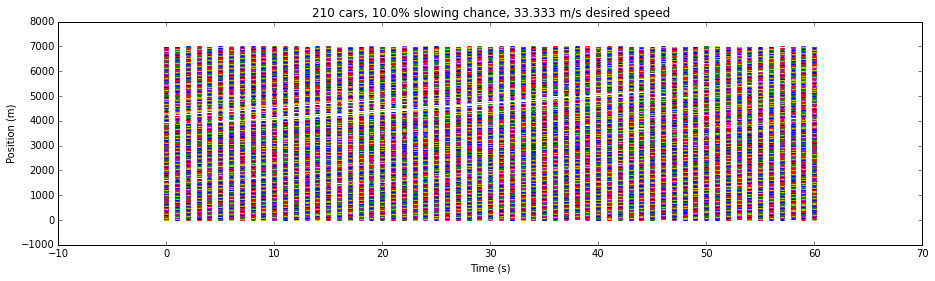

In [10]:
%%timeit
data = run_trial(num_trials=20, discard_steps=60, run_steps=60, num_cars=210,
              slowing_chance=0.1, desired_speed=33.333, length=7000, hard_road=True)
means, stdevs = [i[2] for i in data], [i[3] for i in data]


In [37]:
print('Average speed: {}, St Dev: {}'.format(st.mean(means), st.stdev(stdevs)))

Average speed: 24.87690983606558, St Dev: 1.4355977205707515


##Full scale-up
We'll try 100 trials in order to get the mean and standard deviation. The suggested speed limit will be set as the mean speed plus one standard deviation (rounded to the nearest integer).

mean: 19.568278688524597 std: 8.555005307279394


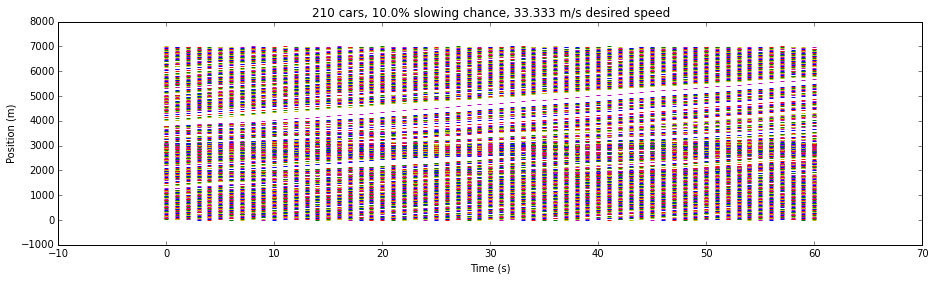

In [11]:
data = run_trial(num_trials=100, discard_steps=60, run_steps=60, num_cars=210,
              slowing_chance=0.1, desired_speed=33.333, length=7000, hard_road=True)
means, stdevs = [i[2] for i in data], [i[3] for i in data]

In [12]:
print('Average speed: {}, St Dev: {}'.format(st.mean(means), st.stdev(stdevs)))

Average speed: 22.821365081967215, St Dev: 2.009230994130149


###According to this simulation, the recommended speed would be ~22.8 + 2 ==> 25 m/s (90 kmh), so let's try that as the desired speed, and see what happens:

mean: 21.59016393442623 std: 3.9229340357104325


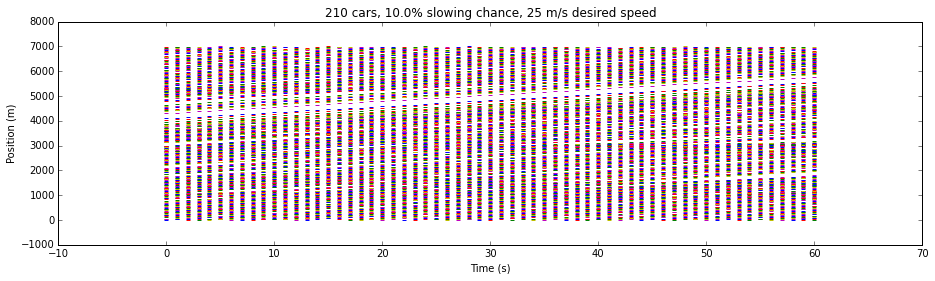

In [14]:
data = run_trial(num_trials=100, discard_steps=60, run_steps=60, num_cars=210,
              slowing_chance=0.1, desired_speed=25, length=7000, hard_road=True)
means, stdevs = [i[2] for i in data], [i[3] for i in data]

In [15]:
print('Average speed: {}, St Dev: {}'.format(st.mean(means), st.stdev(stdevs)))

Average speed: 20.601639344262296, St Dev: 1.8402936126967204


##Conclusions
Setting the speed limit in this way did not seem to make a major difference in the average speed, though it did lower it by approximately 2 m/s. It is possible that the lower standard deviation indicates more slightly more steady traffic speed. Certainly, the difference in the average speed and desired speed is much smaller for this lowered speed limit, which one could argue would result in less frustration for the drivers. One further assumption that has been used here is that all drivers have the same ideal speed, and they never go above that speed. In the real world, the effect of posted speed limits on driver behavior is obviously more nuanced. Nonetheless, these results provide interesting insights into traffic patterns generated solely from simulation results.

More generally, it is difficult to assess whether this model is yielding accurate results, with no simple way to validate the data against real traffic. Nonetheless, the trends in traffic patterns did appear to be realistic, and the appearance and dissipation of phantom "traffic waves" mirrors a real phenomenon of typical highway driving.